In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

%load_ext autoreload
%autoreload 2

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Iterative weight pruning 

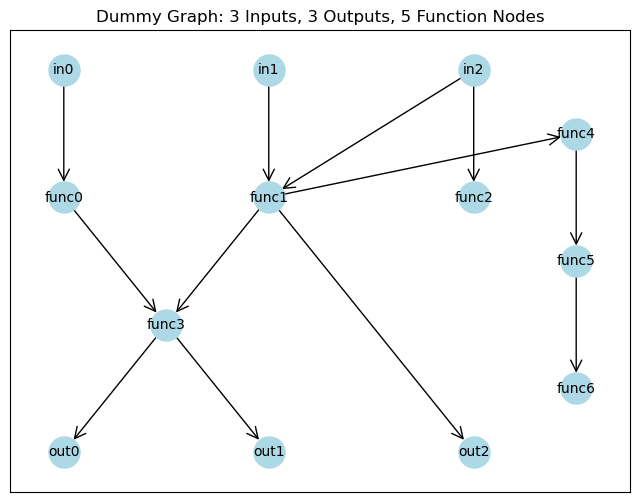

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4', 'func5', 'func6']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func3'), ('func1', 'func4'), ('func4', 'func5'), ('func5', 'func6')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func3', 'out1'), ('func1', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 
    'func4': (3, 1.5), 'func5': (3, 0.5), 'func6': (3, -0.5),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                     'func0': lambda x: np.mean(([(xx)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}

x_train, x_test, y_train, y_test = simulate(G, n_train=1000, n_test=0, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)
y_train = (y_train - y_mu)/(y_std + 1e-8)


# First, let's see how it performs without pruning

In [5]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=10, 
             layers=4,
             share_layers=False, 
             bias=True,
             add_function_self_edges=False,
             norm='none', 
             dropout=0).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)
crit = torch.nn.MSELoss()


losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

n params 1009


In [6]:
# show the relevant function groups in lin1. 
src, dst = model.ResBlocks[0].lin_in.indices
print('[LIN_IN] function groups with at least one weight/indices:', model.ResBlocks[0].channel_groups[dst].unique())

src, dst = model.ResBlocks[0].lin_out.indices
print('[LIN_OUT] function groups with at least one weight/indices:', model.ResBlocks[0].channel_groups[src].unique())

[LIN_IN] function groups with at least one weight/indices: tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
[LIN_OUT] function groups with at least one weight/indices: tensor([0, 1, 3, 4, 5], device='cuda:0')


# Now, let's try with pruning 

In [21]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=10, 
             layers=4,
             share_layers=False, 
             bias=True,
             add_function_self_edges=False,
             norm='none', 
             dropout=0).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)
crit = torch.nn.MSELoss()


losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    if ((i % 100) == 0) and (i > 0): 
        # prune weights 
        model.prune(threshold=1e-1, verbose=True)
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

n params 1009
Pruned in/out: 30, 26 -> remaining in/out: 60, 54
Pruned in/out: 13, 5 -> remaining in/out: 47, 49
Pruned in/out: 1, 2 -> remaining in/out: 46, 47
Pruned in/out: 2, 1 -> remaining in/out: 44, 46
Pruned in/out: 2, 2 -> remaining in/out: 42, 44
Pruned in/out: 1, 0 -> remaining in/out: 41, 44
Pruned in/out: 0, 2 -> remaining in/out: 41, 42
Pruned in/out: 1, 1 -> remaining in/out: 40, 41
Pruned in/out: 2, 3 -> remaining in/out: 38, 38


In [22]:
# show the relevant function groups in lin1. 
src, dst = model.ResBlocks[0].lin_in.indices
print('[LIN_IN] function groups with at least one weight/indices:', model.ResBlocks[0].channel_groups[dst].unique())

src, dst = model.ResBlocks[0].lin_out.indices
print('[LIN_OUT] function groups with at least one weight/indices:', model.ResBlocks[0].channel_groups[src].unique())

[LIN_IN] function groups with at least one weight/indices: tensor([0, 1, 3], device='cuda:0')
[LIN_OUT] function groups with at least one weight/indices: tensor([0, 1, 3], device='cuda:0')


In [ ]:
# note that the only remaining edges are those relevant to function nodes 0,1,3 
# - which are the only function nodes that are relevant to the output nodes.